In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Trade Optimization

# cf: https://github.com/jamesdellinger/ai_for_trading_nanodegree_alpha_research_multi_factor_modeling_project
# To do: 
# - use this to identify factors
# - implement unit tests
# - backtest factors which show promise


In [2]:
import sys
import cvxpy as cvx
import numpy as np
import pandas as pd
import time

sys.path.insert(1,"C:/Users/User/OneDrive/Documents/eftempgithub/3.ZiplineDemo/Helper_Functions")

import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)


In [3]:
import os
import helper, helper_ZAEQ
from zipline.data import bundles
from trading_calendars import get_calendar
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume

ingest_func = bundles.csvdir.csvdir_equities(['daily'], helper_ZAEQ.EOD_BUNDLE_NAME)
bundles.register(helper_ZAEQ.EOD_BUNDLE_NAME, ingest_func)

from zipline.pipeline.domain import ZA_EQUITIES
bundle_data = bundles.load('ZAEQ')
domain_za = ZA_EQUITIES
engine = helper.build_pipeline_engine(bundle_data, domain_za)


In [4]:
# ## View Data

universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')
universe = AverageDollarVolume(window_length=120).top(100) 

universe_tickers = engine    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()


In [5]:
# ## Returns

from zipline.data.data_portal import DataPortal
from trading_calendars import get_calendar
trading_calendar = get_calendar('XJSE')

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

five_year_returns =     get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

In [6]:
# ## Fit PCA

from sklearn.decomposition import PCA

def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """

    pca = PCA(n_components = num_factor_exposures, svd_solver = svd_solver)
    pca.fit(returns)
    
    return pca

num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

<BarContainer object of 20 artists>

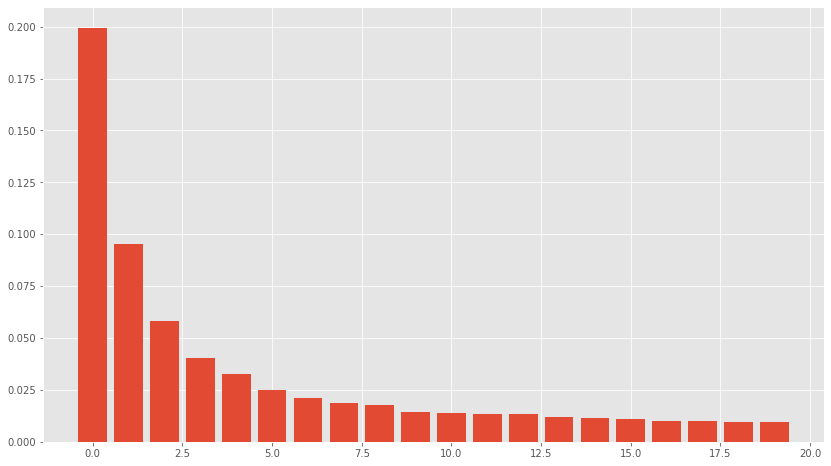

In [7]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

In [8]:
# ## Factor Betas

def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1

    return pd.DataFrame(pca.components_.T,factor_beta_indices,factor_beta_columns)


In [9]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

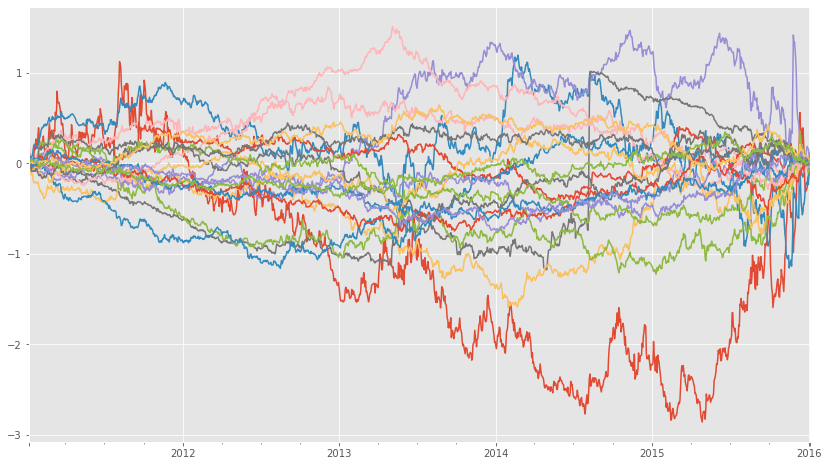

In [10]:
# ## Factor Returns

def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1

    return pd.DataFrame(pca.transform(returns.values),factor_return_indices,factor_return_columns)

risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

risk_model['factor_returns'].cumsum().plot(legend=None);


In [11]:
# ## Factor Covariance Matrix


def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : DataFrame
        Factor covariance matrix
    """
    return np.diag(factor_returns.var(axis=0,ddof=1)*ann_factor)


ann_factor = 252
# project_tests expect factor_cov_matrix() to return a ndarray, 
# but predict_portfolio_risk() expects risk_model['factor_cov_matrix'] 
# to be a dataframe
risk_model['factor_cov_matrix'] = pd.DataFrame(factor_cov_matrix(risk_model['factor_returns'], ann_factor))

In [12]:
# ## Idiosyncratic Variance Matrix
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    common_returns_=pd.DataFrame(np.dot(factor_returns,factor_betas.T),returns.index,returns.columns)
    residuals_=returns-common_returns_
    return pd.DataFrame(np.diag(np.var(residuals_))*ann_factor,returns.columns,returns.columns)

risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)


In [13]:
# ## Idiosyncratic Variance Vector

def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    return pd.DataFrame(np.diagonal(idiosyncratic_var_matrix), returns.columns)

risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])


In [14]:
# ## Predict using the model risk

def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2
    return np.sqrt(weights.T.dot(factor_betas.dot(factor_cov_matrix.dot(factor_betas.T)) + idiosyncratic_var_matrix).dot(weights)).iloc[0][0]

all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.11822120543913815

In [15]:
# # Create Sectors Classifier

factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
from zipline.pipeline.classifiers import Classifier
from zipline.utils.numpy_utils import int64_dtype

universe_tickers = bundle_data.asset_finder.retrieve_all(bundle_data.asset_finder.sids)

data = pd.read_csv('C:/Users/User/OneDrive/Documents/Finance/Quant/Zipline/2.Examples/1.Research_Environment/Sectors.csv',
   index_col = 0)
data.index = data.index.str.replace(' SJ','')
data = data['ICB_SUPERSECTOR_NAME']
dict_asset_sector = data.to_dict()
sector = np.unique(data[~pd.isnull(data)])
dict_sector_int = pd.DataFrame(index = sector, 
                            columns = ['sector'],
                            data = np.arange(len(sector)))\
                                    .to_dict()['sector']

isector = np.zeros(len(universe_tickers))

for k in range(len(universe_tickers)):
    try:
        isector[k] = dict_sector_int[dict_asset_sector[universe_tickers[k].symbol]]
    except KeyError:
        isector[k] = np.nan     
        
class Sector(Classifier):
    dtype = int64_dtype
    window_length = 0
    inputs = ()
    missing_value = -1

    def __init__(self):

        self.data = isector

    def _compute(self, arrays, dates, assets, mask):
        return np.where(
            mask,
            self.data[assets],
            self.missing_value,
        )
    
sector = Sector()

In [16]:
# ## Create alpha factors

# ### Momentum 1 year

from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe)         .demean(groupby=sector)         .rank()         .zscore()


# ### Mean Reversion 5 Day Sector Neutral

def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    return momentum_1yr(window_length,universe,sector)*-1


# ## Mean Reversion 5 Day Sector Neutral Smoothed Factor

from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, 
                                                universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    
    return SimpleMovingAverage(inputs=[
        mean_reversion_5day_sector_neutral(window_length,
                                           universe, 
                                           sector)],window_length=window_length).rank().zscore()

universe = AverageDollarVolume(window_length=120).top(100)

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)


In [17]:

import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


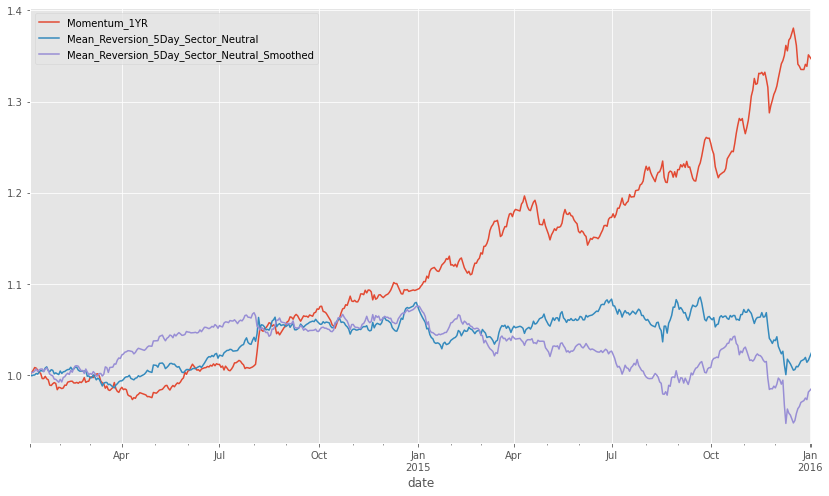

In [18]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot();

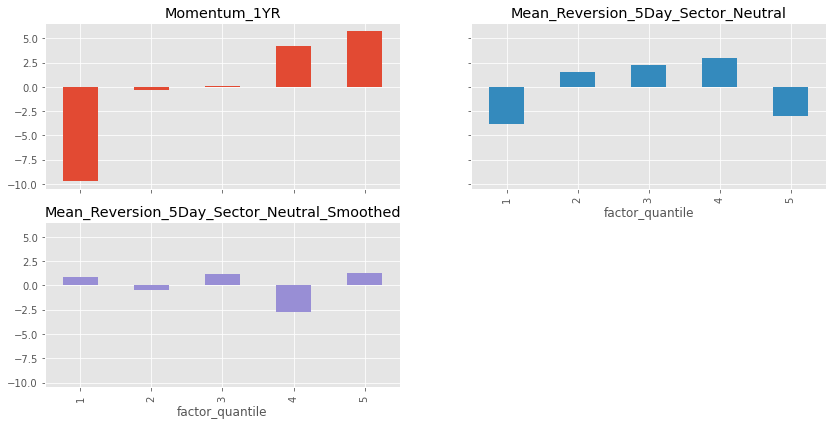

In [19]:
# ##  Basis points per day per quantile

qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);


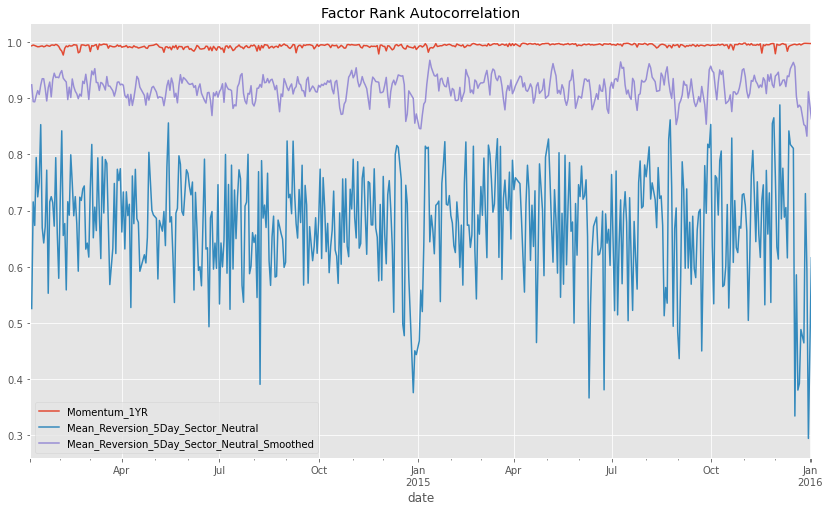

In [20]:
# ## Turnover analysis

ls_FRA = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation");


In [21]:
# ## Sharpe ratio

def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    return annualization_factor*factor_returns.mean()/factor_returns.std()


# In[37]:


daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Momentum_1YR                                   2.39
Mean_Reversion_5Day_Sector_Neutral             0.24
Mean_Reversion_5Day_Sector_Neutral_Smoothed   -0.10
dtype: float64

In [22]:
selected_factors = all_factors.columns[[0,1,2]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]

Selected Factors: Momentum_1YR, Mean_Reversion_5Day_Sector_Neutral, Mean_Reversion_5Day_Sector_Neutral_Smoothed


In [23]:
# # Optimal Portfolio Constrained by Risk Model


from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T @ weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

In [24]:

class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        return cvx.Minimize(-alpha_vector.T.values[0]@weights)
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        return [risk<=self.risk_cap**2,factor_betas.T@weights<=self.factor_max,factor_betas.T@weights>=self.factor_min,
                sum(weights)==0,sum(cvx.abs(weights))<=1,weights>=self.weights_min,weights<=self.weights_max]

    def __init__(self, risk_cap=0.1, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min



optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])


In [25]:
print("leverage = "+str(np.sum(np.abs(optimal_weights)).item())) 
print("largest position = "+str(np.max(np.abs(optimal_weights)).item())) 

leverage = 0.9999999998546316
largest position = 0.27833926954057386


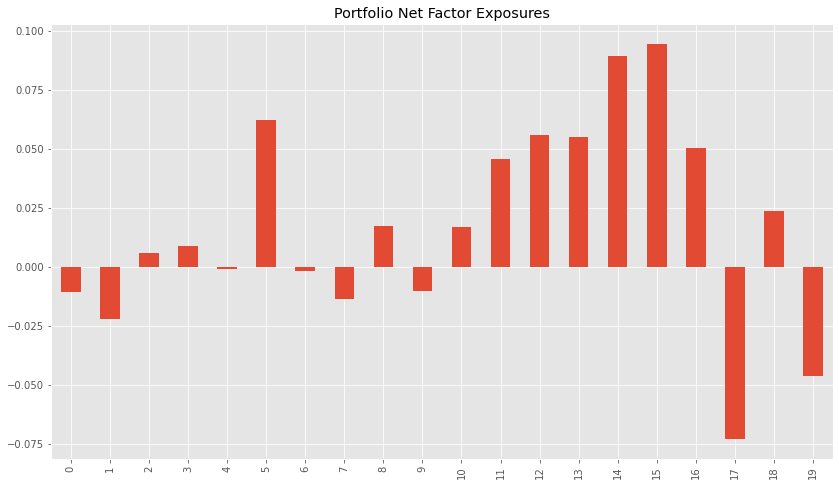

In [26]:

def get_factor_exposures(factor_betas, weights):
    return factor_betas.loc[weights.index].T.dot(weights)

# %%
get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False);


In [27]:
# ## Optimize with a Regularization Parameter


class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
                
        return cvx.Minimize(-alpha_vector.T.values[0]@weights + self.lambda_reg*cvx.pnorm(weights,2))

    def __init__(self, lambda_reg=0.5, risk_cap=0.15, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


In [28]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], 
                                                                      risk_model['factor_cov_matrix'], 
                                                                      risk_model['idiosyncratic_var_vector'])

print("leverage = "+str(np.sum(np.abs(optimal_weights_1)).item())) 
print("largest position = "+str(np.max(np.abs(optimal_weights_1)).item())) 

leverage = 0.9999999996403365
largest position = 0.034275410223696255


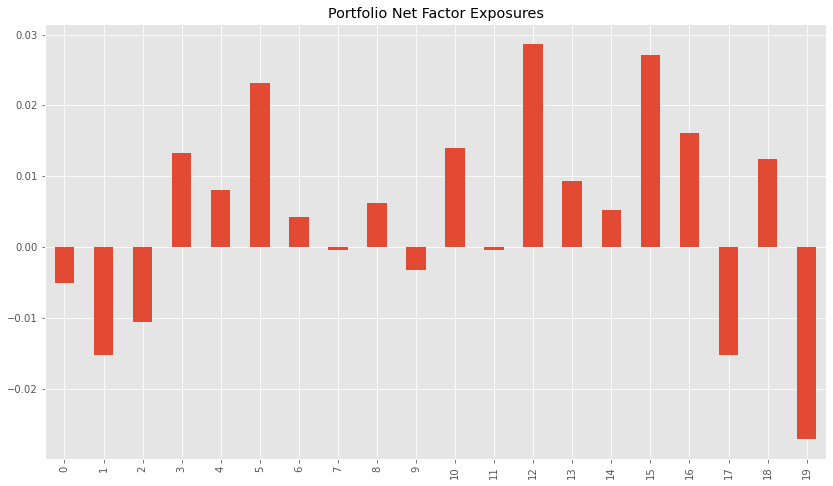

In [29]:

get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False);

In [30]:


class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        alpha_vec_vals=alpha_vector.values[:,0]
        x_star=(alpha_vec_vals-np.mean(alpha_vec_vals))/sum(abs(alpha_vec_vals))
        return cvx.Minimize(cvx.pnorm(weights-x_star,2))


optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.2,
    weights_min=-0.2,
    risk_cap=0.075,
    factor_max=0.15,
    factor_min=-0.15).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

print("leverage = "+str(np.sum(np.abs(optimal_weights_2)).item())) 
print("largest position = "+str(np.max(np.abs(optimal_weights_2)).item())) 

leverage = 1.0000000701921488
largest position = 0.029587539599197004


c:\ProgramData\Anaconda3\envs\env_zipline\lib\site-packages\cvxpy\problems\problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


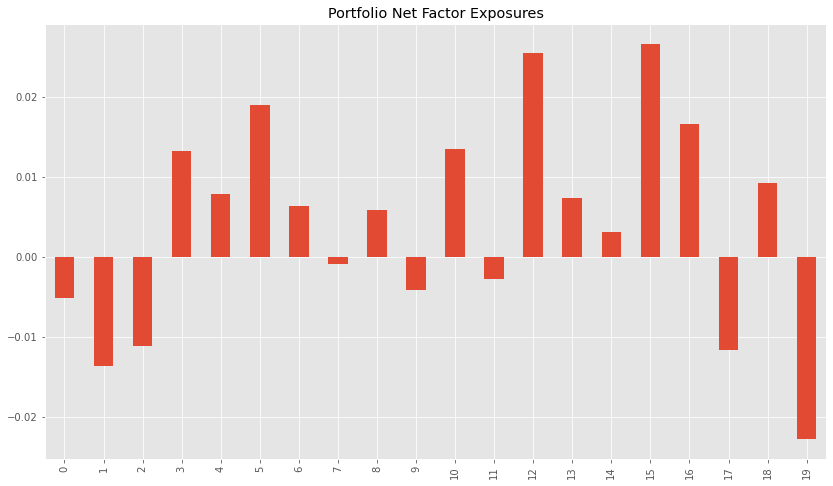

In [31]:

get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False);

Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


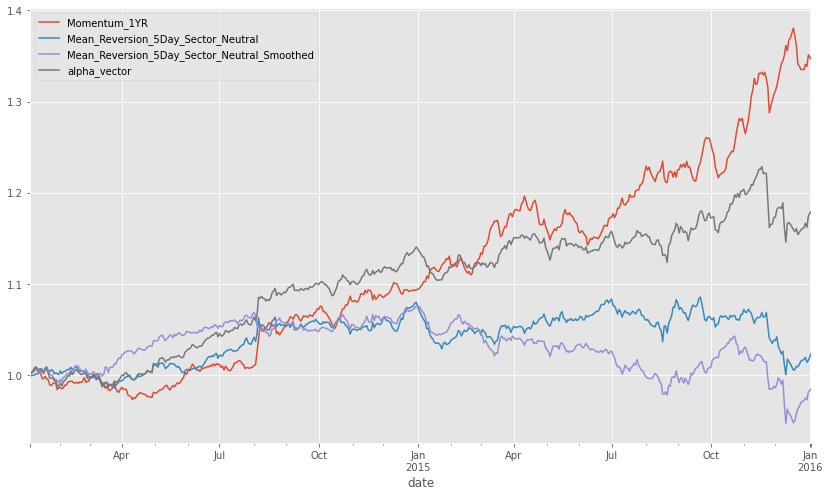

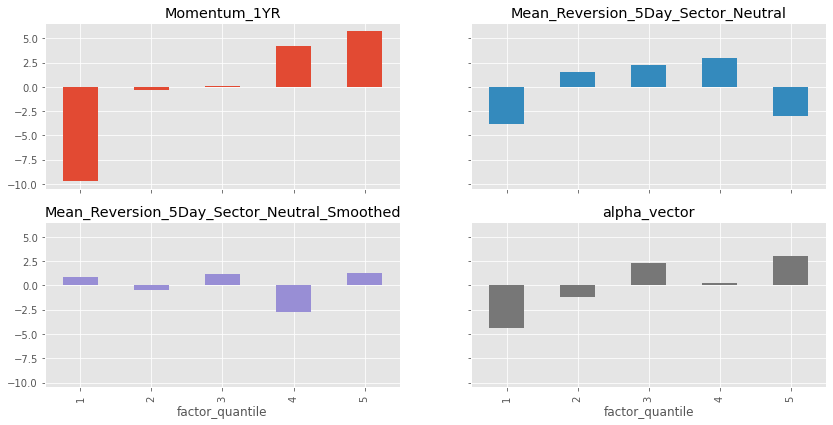

In [32]:

import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot();

qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False);

Momentum_1YR                                   2.39
Mean_Reversion_5Day_Sector_Neutral             0.24
Mean_Reversion_5Day_Sector_Neutral_Smoothed   -0.10
alpha_vector                                   1.39
dtype: float64

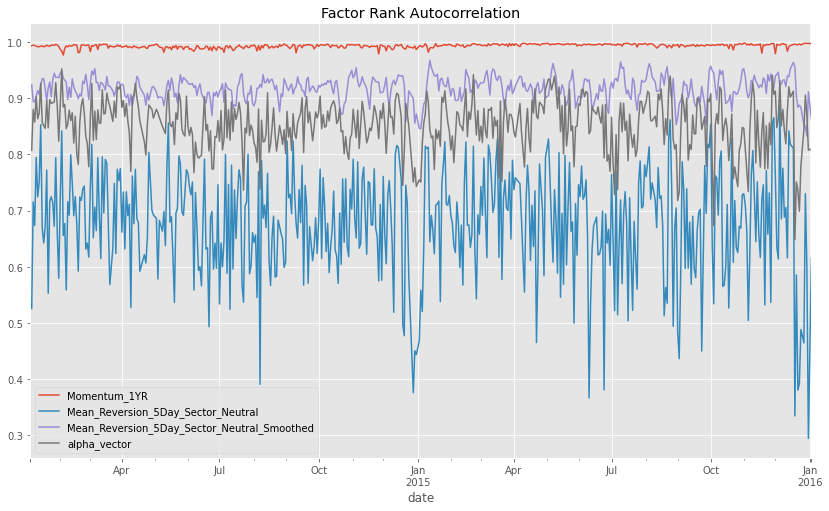

In [33]:
ls_FRA = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation");

daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)